In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D, Conv1D, Concatenate, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

pi = 3.14159265359
maxval = 1e9
minval = 1e-9

2023-02-08 18:38:27.096594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:38:27.331758: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 18:38:27.338760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 18:38:27.338798: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [18]:
train_df = pd.read_csv('train_1Da.csv',nrows=200000)
test_df = pd.read_csv('test_1Da.csv',nrows=10000)

train_df_pos = train_df[train_df['pt']>0]
test_df_pos = test_df[test_df['pt']>0]

train_df_neg = train_df[train_df['pt']<0]
test_df_neg = test_df[test_df['pt']<0]

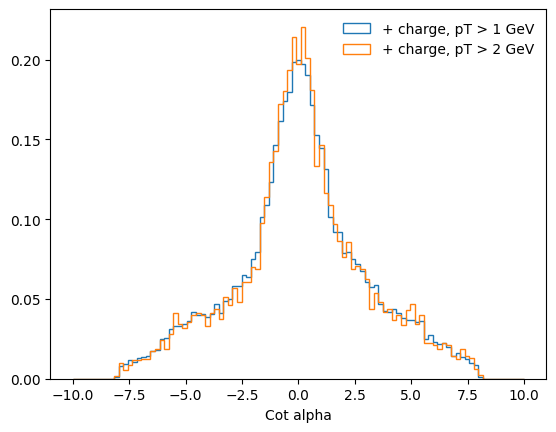

In [22]:
bins = np.linspace(-10,10,100)
plt.hist(train_df_pos['cotAlpha'][train_df_pos['pt']>1],bins=bins,histtype='step',label='+ charge, pT > 1 GeV',density=True)
plt.hist(train_df_pos['cotAlpha'][train_df_pos['pt']>2],bins=bins,histtype='step',label='+ charge, pT > 2 GeV',density=True)
#plt.hist(train_df_neg['cotAlpha'][train_df_neg['pt']<1],bins=bins,histtype='step',label='negative charge, pT > 1 GeV')
#plt.hist(train_df_neg['cotAlpha'][train_df_neg['pt']<2],bins=bins,histtype='step',label='negative charge, pT > 2 GeV')
plt.xlabel('Cot alpha')
plt.legend(frameon=False)

In [10]:
def inverse_cot(cota):
    return np.array([math.fmod(math.atan(1/x)/pi+1,1) for x in cota])

In [11]:
X_train = train_df.drop(columns=['pt','cotAlpha']).values
X_test = test_df.drop(columns=['pt','cotAlpha']).values

y_train = inverse_cot(train_df['cotAlpha'].values)
y_test = inverse_cot(test_df['cotAlpha'].values)

In [12]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

(array([1091.,  495.,  400.,  336.,  279.,  302.,  332.,  392.,  497.,
         946.]),
 array([0.03958591, 0.13166892, 0.22375193, 0.31583494, 0.40791795,
        0.50000096, 0.59208397, 0.68416699, 0.77625   , 0.86833301,
        0.96041602]),
 <BarContainer object of 10 artists>)

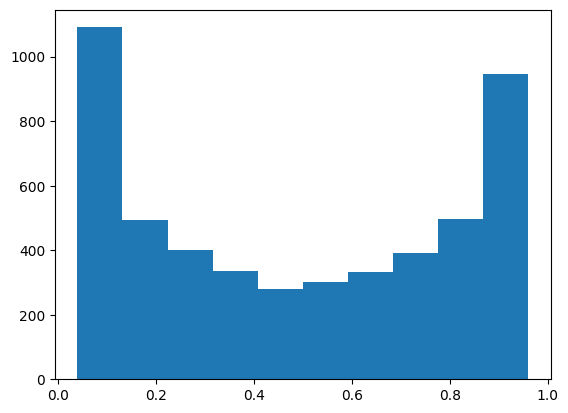

In [13]:
plt.hist(y_test)

2023-02-08 18:40:43.844207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 18:40:43.844401: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 18:40:43.844487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-02-08 18:40:43.847866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


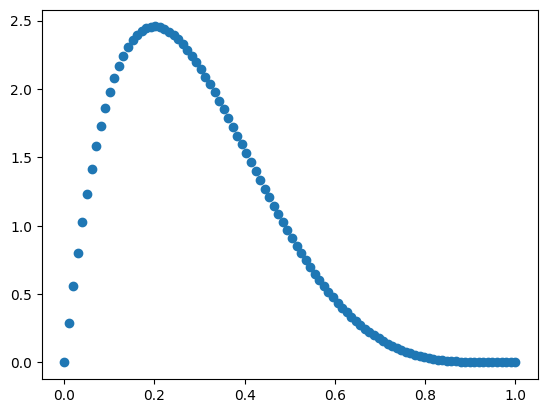

In [14]:
dist = tfp.distributions.Beta(concentration1 = 2,
                              concentration0 = 5)
    
xpoints = np.linspace(0,1,100)
plt.scatter(xpoints,dist.prob(xpoints)) 

In [15]:
def param_transform(par):
    return 1/(minval+tf.math.softplus(par))

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [16]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("elu", name="elu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("elu", name="elu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("elu", name="elu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=beta_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 elu1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 elu2 (Activation)           (None, 64)                0         
                                                             

In [17]:
#es = EarlyStopping(patience=20,
#                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    #callbacks=[es],
                    epochs=1000, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
1266/1266 [==============================] - 11s 6ms/step - loss: -0.1771 - val_loss: -0.2730
Epoch 2/1000
1266/1266 [==============================] - 7s 6ms/step - loss: -0.2616 - val_loss: -0.2875
Epoch 3/1000
1266/1266 [==============================] - 7s 5ms/step - loss: -0.2744 - val_loss: -0.2975
Epoch 4/1000
1266/1266 [==============================] - 8s 6ms/step - loss: -0.2823 - val_loss: -0.3012
Epoch 5/1000
1266/1266 [==============================] - 6s 5ms/step - loss: -0.2889 - val_loss: -0.3027
Epoch 6/1000
1266/1266 [==============================] - 7s 5ms/step - loss: -0.2928 - val_loss: -0.3070
Epoch 7/1000
1266/1266 [==============================] - 6s 5ms/step - loss: -0.2962 - val_loss: -0.3043
Epoch 8/1000
1266/1266 [==============================] - 7s 6ms/step - loss: -0.2999 - val_loss: -0.3143
Epoch 9/1000
1266/1266 [==============================] - 7s 5ms/step - loss: -0.3020 - val_loss: -0.3076
Epoch 10/1000
1266/1266 [====================

KeyboardInterrupt: 

In [ ]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [ ]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Atrue'] = y_test*pi
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])
df['mean'] = df['alpha']/(df['alpha']+df['beta'])*pi
df['mode'] = (df['alpha']-1)/(df['alpha']+df['beta']-2)*pi
df['sigma'] = tf.math.sqrt(df['alpha']*df['beta']/((df['alpha']+df['beta'])*(df['alpha']+df['beta'])*(df['alpha']+df['beta']+1)))*pi

#df.to_csv("test_1DcotAGauss.csv",header=False,index=False)

In [ ]:
residuals = df['Atrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

In [ ]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha-\mu$ [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

In [ ]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

In [ ]:
plt.hist(df['Atrue'],bins=np.linspace(0,pi,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(0,pi,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(0,pi,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
plt.legend()
plt.show()

In [ ]:
plt.scatter(df['Atrue'],df['sigma'])
plt.ylim(-10,25)

In [ ]:
pulls = residuals/df['sigma']

In [ ]:
plt.hist(pulls,bins=np.linspace(-10,10,50));
plt.xlabel('pull')

In [ ]:
print(np.mean(pulls),np.std(pulls))